## Effects of ENSO and IOD on Borneo rainfall.

Here we investigate the effects of El Nino Southern Oscillation (ENSO) and Indian Ocean Dipole (IOD) on mean precipitaion over Indonesian Borneo (BorneoP) in the boreal summer months (JJA).

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import os

import iris
import iris.coord_categorisation
import datetime
from iris.time import PartialDateTime

import iris.quickplot as qplt

from iris.pandas import as_cube, as_series, as_data_frame
import cf_units


from scipy import signal
import scipy.stats as stats

import statsmodels.api as sm
import pandas as pd

import copy

import sklearn.linear_model as ML


# Load data JJA means

In [ ]:
year_constraint = iris.Constraint(season_year=lambda v: v > 1980 and v <= 2014 )

In [2]:
precip_Borneo = iris.load_cube('Borneo_precip_chirps_mean.nc', 'Climate Hazards group InfraRed Precipitation with Stations')
precip_Borneo = precip_Borneo.extract(year_constraint)

In [3]:
enso           = iris.load_cube(DATA_PATH + "enso_jja.nc") 

In [4]:
iod             = iris.load_cube(DATA_PATH + "iod_jja.nc") 

In [20]:
print(np.shape(precip_Borneo),np.shape(enso),np.shape(iod))

(70,) (70,) (70,) (70,)


## Standardize and Detrend

1.0


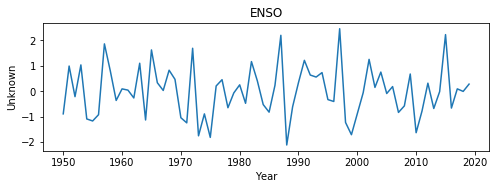

In [9]:
enso_trend = enso - signal.detrend(enso.data)
enso_det = enso - enso_trend
ENSO = (enso_det - np.mean(enso_det.data))/np.std(enso_det.data)

pBorneo_trend = precip_Borneo - signal.detrend(precip_Borneo.data)
pBorneo_det = precip_Borneo  - pBorneo_trend
PBORNEO = (pBorneo_det - np.mean(pBorneo_det.data))/np.std(pBorneo_det.data)

iod_trend = iod - signal.detrend(iod.data)
iod_det = iod  - iod_trend
DMI = (iod_det  - np.mean(iod_det .data))/np.std(iod_det .data)

Vars = {'enso':ENSO , 'pBorneo': PBORNEO,  'dmi':DMI}

# To verify whether variables are standardized and detrended
fig = plt.figure(figsize=(8, 8))
plt.subplot(311)
qplt.plot(ENSO)
plt.title('ENSO')
print (np.std (ENSO.data))

# Preliminary Ananlysis
## Bivariate regression/correlation coeff

In [47]:
Reg_Enso  = {'enso':0 , 'pBorneo': 0, 'dmi':0, 'IndonesianSST':0}
Reg_pBorneo   = {'enso':0,  'pBorneo': 0,  'dmi':0, 'IndonesianSST':0}
Reg_dmi   = {'enso':0,  'pBorneo': 0, 'dmi':0, 'IndonesianSST':0}

Regs = {'enso':Reg_Enso , 'pBorneo': Reg_pBorneo,  'dmi':Reg_dmi}

Corrs = {'enso':Reg_Enso , 'pBorneo': Reg_pBorneo,  'dmi':Reg_dmi}

In [48]:
for var1 in Vars:
    var1_data = Vars[var1].data
    for var2 in Vars:
        var2_data = Vars[var2].data
        
        res = stats.linregress(var1_data,var2_data)   # Y,X

        Regs[var1][var2]  = np.round(res[0],decimals=3)
        Corrs[var1][var2] = np.round(res[2],decimals=3)
        

In [49]:
for var1 in Vars:
    print(var1,' correlations:')
    print(Corrs[var1])

enso  correlations:
{'enso': 1.0, 'pBorneo': -0.516, 'dmi': 0.239, 'IndonesianSST': -0.345}
pBorneo  correlations:
{'enso': -0.516, 'pBorneo': 1.0, 'dmi': -0.209, 'IndonesianSST': 0.285}
dmi  correlations:
{'enso': 0.239, 'pBorneo': -0.209, 'dmi': 1.0, 'IndonesianSST': -0.735}
IndonesianSST  correlations:
{'enso': -0.345, 'pBorneo': 0.285, 'dmi': -0.735, 'IndonesianSST': 1.0}


In [50]:
for var1 in Vars:
    print('Y = ',var1,' regressed on X:')
    print(Regs[var1])

Y =  enso  regressed on X:
{'enso': 1.0, 'pBorneo': -0.516, 'dmi': 0.239, 'IndonesianSST': -0.345}
Y =  pBorneo  regressed on X:
{'enso': -0.516, 'pBorneo': 1.0, 'dmi': -0.209, 'IndonesianSST': 0.285}
Y =  dmi  regressed on X:
{'enso': 0.239, 'pBorneo': -0.209, 'dmi': 1.0, 'IndonesianSST': -0.735}
Y =  IndonesianSST  regressed on X:
{'enso': -0.345, 'pBorneo': 0.285, 'dmi': -0.735, 'IndonesianSST': 1.0}


# IOD --> pBorneo <-- ENSO 
## Regressions for each var that has parents (i.e. pBorneo)

In [70]:
# Precip TARGET
Y_p = Vars['pBorneo'].data
X_p = np.stack([Vars['enso'].data]).T

reg_p = ML.LinearRegression(fit_intercept=False, normalize=False).fit(X_p, Y_p)

CausalEffect_precip = {'enso': round(reg_p.coef_[0],2)}

print('Causal effect on Borneo precip (ENSO only)')
print(CausalEffect_precip )

Causal effect on Borneo precip (ENSO only)
{'enso': -0.52}


In [71]:
# Precip TARGET
Y_p = Vars['pBorneo'].data
X_p = np.stack([Vars['dmi'].data]).T

reg_p = ML.LinearRegression(fit_intercept=False, normalize=False).fit(X_p, Y_p)

CausalEffect_precip = {'dmi': round(reg_p.coef_[0],2)}

print('Causal effect on Borneo precip (IOD only)')
print(CausalEffect_precip )

Causal effect on Borneo precip (IOD only)
{'dmi': -0.21}


In [72]:
# Precip TARGET
Y_p = Vars['pBorneo'].data
X_p = np.stack([Vars['enso'].data, Vars['dmi'].data]).T

reg_p = ML.LinearRegression(fit_intercept=False, normalize=False).fit(X_p, Y_p)

CausalEffect_precip = {'IndonesianSST': round(reg_p.coef_[0],2), 'enso':round(reg_p.coef_[1],2), 'dmi':round(reg_p.coef_[2],2)}

print('Causal effect on Borneo precip (all drivers)')
print(CausalEffect_precip )

Causal effect on Borneo precip (all drivers)
{'IndonesianSST': 0.11, 'enso': -0.47, 'dmi': -0.01}
